In [18]:
import torch
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

import sys
sys.path.append('../src')
from train_multilabel import MultilabelResNet,load_multilabel_model
from harvest_data_single_label import parse_CHO, EuropeanaAPI
from download_images import url2img
from gradcam import predict_grad_cam, plot_grad_cam



In [19]:
model_path = '../model_zoo/multilabel'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model,class_index_dict = load_multilabel_model(model_path, device)
model.eval()

MultilabelResNet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [26]:
class_index_dict

{0: 'building',
 1: 'ceramics',
 2: 'drawing',
 3: 'furniture',
 4: 'inscription',
 5: 'jewellery',
 6: 'map',
 7: 'painting',
 8: 'photograph',
 9: 'postcard',
 10: 'sculpture',
 11: 'tapestry',
 12: 'textile',
 13: 'toy',
 14: 'woodwork'}

In [41]:
eu = EuropeanaAPI('api2demo')
reusability = 'open' # open, permission or restricted
CHO_list = eu.search(
    query = 'drawing',
    reusability = reusability,
    n = 10)

URI:  http://data.europeana.eu/item/90402/RP_T_1918_309


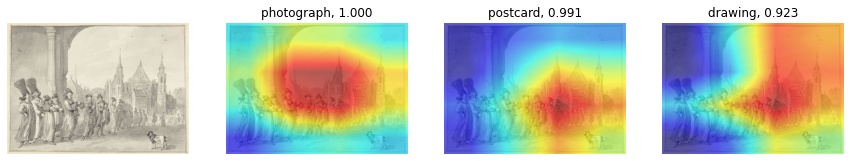

URI:  http://data.europeana.eu/item/11601/HERBARWXNHMVXAUSTRIAX169315


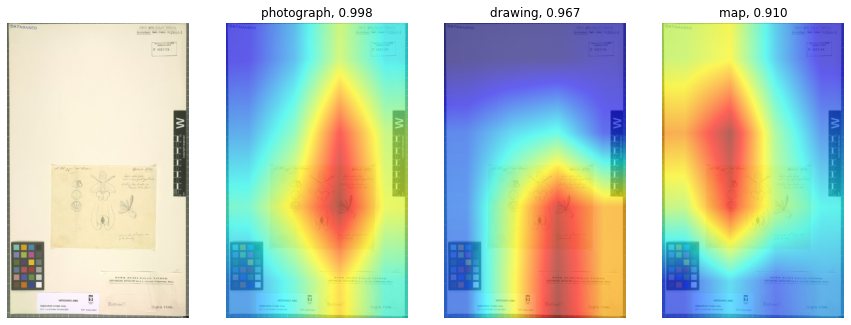

URI:  http://data.europeana.eu/item/90402/RP_T_1930_44


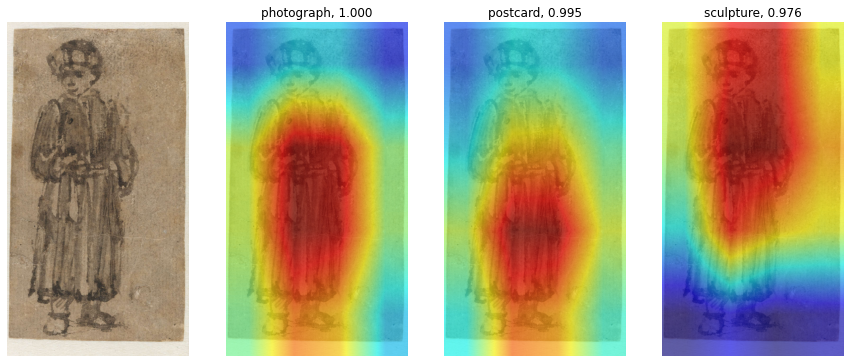

URI:  http://data.europeana.eu/item/2048005/Athena_Plus_ProvidedCHO_Nationalmuseum__Sweden_56508
Failed to get media image
URI:  http://data.europeana.eu/item/90402/RP_T_1955_226


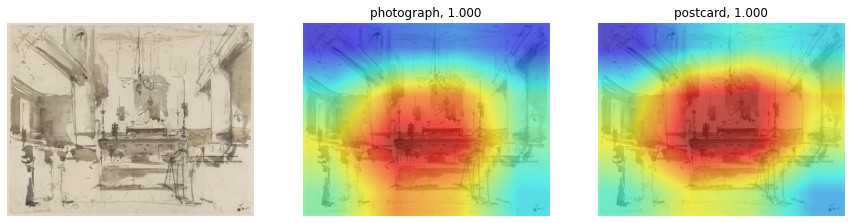

URI:  http://data.europeana.eu/item/90402/RP_T_00_3534


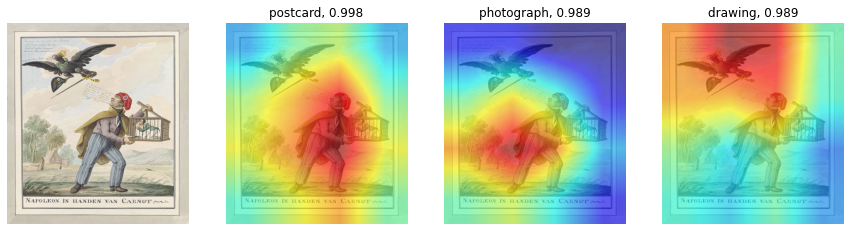

URI:  http://data.europeana.eu/item/90402/RP_T_1933_54_R_


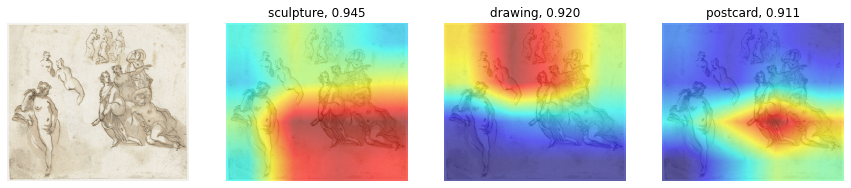

URI:  http://data.europeana.eu/item/90402/RP_T_1914_17_205


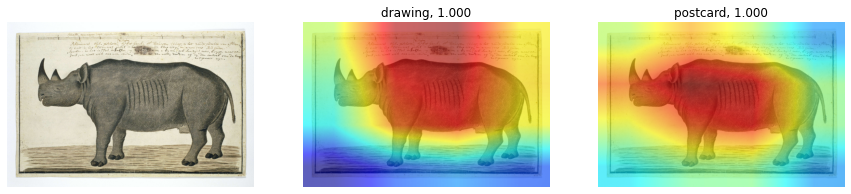

URI:  http://data.europeana.eu/item/2020903/KKSgb4426


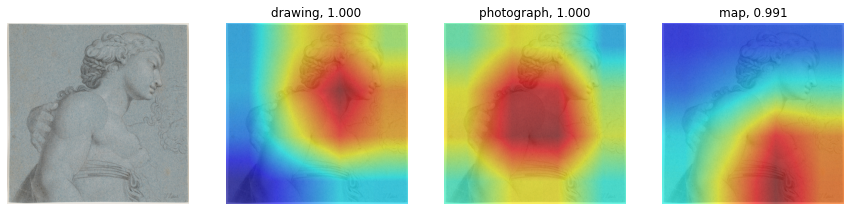

URI:  http://data.europeana.eu/item/90402/RP_T_BR_2017_1_10_93


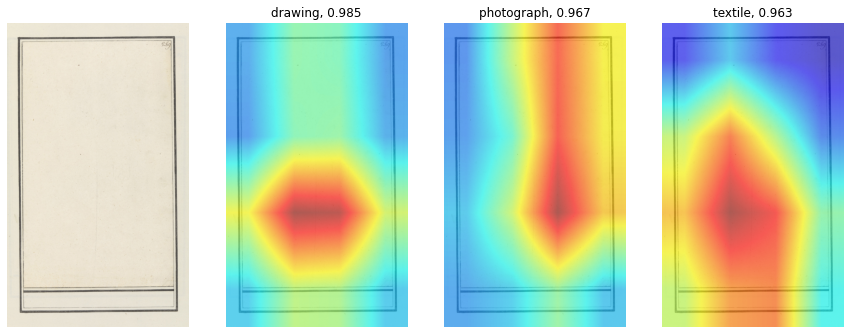

In [42]:
transform = transforms.Compose([
transforms.Resize((128,128)),
transforms.ToTensor(),
transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

for CHO in CHO_list:
    ID,URI,URL = parse_CHO(CHO)
    
    print('URI: ',URI)

    image = url2img(URL)
    if not image:
        continue

    category_list, confidence_list, XAI_list = predict_grad_cam(
        model = model, 
        class_index_dict = class_index_dict,
        image = image,
        heatmap_layer = model.net.layer4[1].conv2, 
        transform = transform, 
        device = device, 
        thres = 0.5, 
        max_pred = 3)
    
    plot_grad_cam(
        image = image,
        category_list = category_list, 
        confidence_list = confidence_list,
        XAI_list = XAI_list,
    )
    
    plt.show()
        